In [ ]:
!pip install torchmetrics datasets

# Define Model Training Function

In [ ]:
# Import necessary libraries
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as c
import torch.nn.functional as F
from google.colab import drive
from torchmetrics import Accuracy, ConfusionMatrix

# Mount Google Drive
drive.mount('/content/drive')

# Paths
train_root = '/content/drive/MyDrive/your_google_drive_path'
test_root = '/content/drive/MyDrive/your_google_drive_path'


dataset = datasets.ImageFolder(root=train_root)
print(dataset.classes)

num_classes = 3

def test(model, test_loader, metrics, device):
  for key, metric in metrics.items():
    metric.reset()
    metric.to(device)

  model.eval()
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)

          for key, metric in metrics.items():
              metric(outputs, labels)

  return metrics

def train(model, train_loader, criterion, optimizer, metrics, device):
  train_loss = 0.0
  n_samples = 0
  for key, metric in metrics.items():
    metric.reset()
    metric.to(device)

  model.train()
  for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * inputs.size(0)
      n_samples += inputs.size(0)

      for key, metric in metrics.items():
          metric(outputs, labels)

  train_loss /= n_samples
  return train_loss, metrics


def run(model, optimizer, train_transform, test_transform, num_epochs=10, batch_size=64):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  train_dataset = datasets.ImageFolder(root=train_root, transform=train_transform)
  test_dataset = datasets.ImageFolder(root=test_root, transform=test_transform)

  samples_per_class = torch.tensor([9, 18+13, 25], dtype=torch.float32)
  weights = 1 / samples_per_class
  weights = weights.to(device)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

  criterion = nn.CrossEntropyLoss(weight=weights)

  train_metrics = {"Accuracy": Accuracy(task="multiclass", num_classes=num_classes), "Confusion_Matrix": ConfusionMatrix(task="multiclass", num_classes=num_classes)}
  test_metrics = {"Accuracy": Accuracy(task="multiclass", num_classes=num_classes), "Confusion_Matrix": ConfusionMatrix(task="multiclass", num_classes=num_classes)}
  for epoch in range(num_epochs):
    train_loss, _ = train(model, train_loader, criterion, optimizer, train_metrics, device)
    test(model, test_loader, test_metrics, device)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics["Accuracy"].compute().item():.4f}, Test Accuracy: {test_metrics["Accuracy"].compute().item():.4f}')

  return train_metrics, test_metrics

Mounted at /content/drive
['Cross', 'Offset', 'T']


#Model Training--ResNet CNN (3 class)

In [ ]:
# Load pre-trained ResNet model
num_classes = 3  # Update based on your dataset
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

optimizer = optim.Adam(model.parameters(), lr=5e-4)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_metrics, test_metrics = run(model, optimizer, train_transform, test_transform, num_epochs=5)

# Print final metrics
print(f"Final Train Accuracy: {train_metrics['Accuracy'].compute().item():.4f}")
print(f"Final Test Accuracy: {test_metrics['Accuracy'].compute().item():.4f}")


# Save the model's state dictionary
save_path = '/content/drive/My Drive/your_google_drive_path/your_saving_file_name.pth'
torch.save(model.state_dict(), save_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.5471, Train Accuracy: 0.3363, Test Accuracy: 0.5854
Epoch 2/5, Train Loss: 0.7818, Train Accuracy: 0.6903, Test Accuracy: 0.5854
Epoch 3/5, Train Loss: 0.5831, Train Accuracy: 0.6460, Test Accuracy: 0.6341
Epoch 4/5, Train Loss: 0.4146, Train Accuracy: 0.7257, Test Accuracy: 0.7073
Epoch 5/5, Train Loss: 0.3115, Train Accuracy: 0.8230, Test Accuracy: 0.6829
Final Train Accuracy: 0.8230
Final Test Accuracy: 0.6829


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

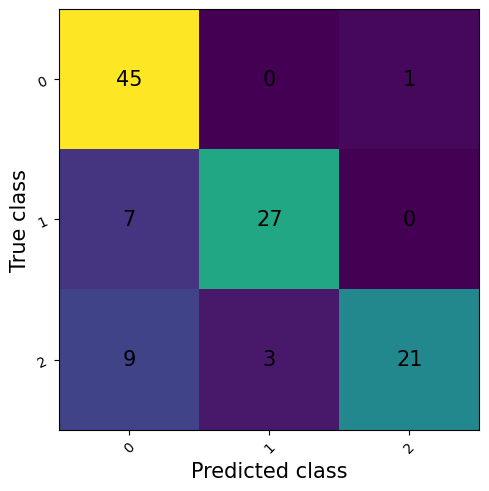

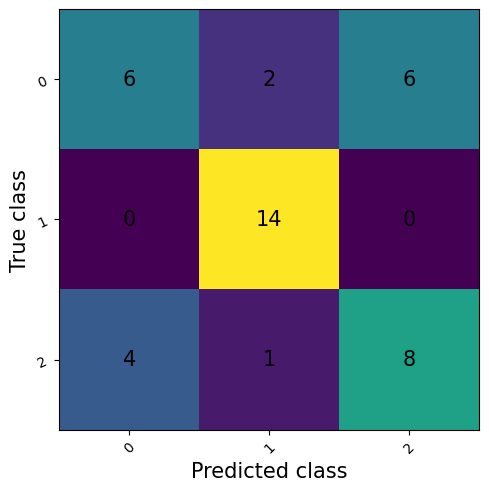

In [ ]:
train_metrics["Confusion_Matrix"].plot()
test_metrics["Confusion_Matrix"].plot()